<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Regularization

_Authors: Kiefer Katovich (SF), Justin Pounders_

---

### Learning Objectives

- Define and describe regularization for regression models
- Write the regularized loss function
- Describe how regularization affects regression coefficients
- Describe the differences between the Lasso, Ridge, and ElasticNet models
- Implement and visualize the penalties using sklearn

### Lesson Guide
- [Overview of regularization](#intro)
- [What is the effect of regularization](#effect)
- [Standardizing predictors is required](#standardization)
- [Defining and visualizing the Ridge](#viz-ridge)
- [Defining and visualizing the Lasso](#viz-lasso)
- [Defining and visualizing the Elastic-Net](#viz-elastic-net)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='intro'></a>

## Overview of regularization

---

### Why regularization?

Before we get to regularization we need to review **overfitting**:

> *Overfitting* means building a model that matches the training data "too closely." The model ends up training on noise rather than signal.

- Usually caused by a model that is too complex 
- Low bias/high variance models

---

**Do you need to worry about overfi!ing with Linear Regression?**

"Good" properties
- Low complexity
- High bias/low variance 
- Does not tend to overfit

Danger zone
- Including irrelevant features (signal v noise)
- (number of features) is close to (number of observations)
- Correlated inputs
- Numerically large coefficients

---

### What is regularization

**The goal of "regularizing" regression models is to structurally prevent overfitting by imposing a penalty on the coefficients of the model.**

Regularization methods like the Ridge and Lasso add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

> In other words, model training becomes a balance between error and the size of the coefficients. 

The two most common types of regularization are the **Lasso**, **Ridge**. There is a mixture of them called the **Elastic Net**. We will take a look at the mathematics of regularization and the effect these penalties have on model fits.


<a id='lsq-loss'></a>

## Review: Least Squares Loss Function

---

Ordinary least squares regression minimizes the mean squared error (MES) to fit the data:

### $$ \text{minimize:}\; MSE(\beta_0, \beta_1, ...) = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

Where our model predictions for $y$ are based on the sum of the $\beta_0$ intercept and the products of $\beta_i$ with $x_i$.

What should I take away from this?

- Machine learning usually boils down to _optimization_
- Training/fitting means _minimizing_ a "loss function" (aka cost or objective function)
- In linear regression, the loss function is MSE, and the optimization is performed with respect to the $\beta$ coefficients.

> Minimizing the loss function gives you the optimal $\beta$ values for your regression model!!


<a id='effect'></a>

## What is the effect of regularization?

---

**To demonstrate the effects we will be using a dataset on wine quality.**

An important aspect of this data, which is a reason why we might choose to use regularization, is that there is **multicollinearity** in the data. The term multicollinearity means that there are _high correlations between predictor variables in your model_. 

**This can lead to a variety of problems including:**
1. The effect of predictor variables estimated by your regression will depend on what other variabes are included in your model.
2. Predictors can have wildly different effects depending on the observations in your sample, and small changes in samples can result in very different estimated effects.
3. With very high multicollinearity, the inverse matrix the computer calculates may not be accurate.
4. We can no longer interpret a coefficient on a variable as the effect on the target of a one unit increase in that variable holding the other variables constant. This is because when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

> **For example:** say I want to predict home prices.  As predictors I have number of bedrooms upstairs, number of bedrooms downstairs and total number of bedrooms.  What could go wrong?!?



### Load the wine csv

This version has red and white wines concatenated together and tagged with a binary 1,0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [2]:
wine = pd.read_csv('./datasets/winequality_merged.csv')

# replace spaces in column names and convert all columns to lowercase:
wine.columns = [x.lower().replace(' ','_') for x in wine.columns]

In [3]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
ph                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
red_wine                6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 659.9 KB


In [5]:
wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


**Look at the correlation between variables.**

In [12]:
wine_corr = wine.corr()

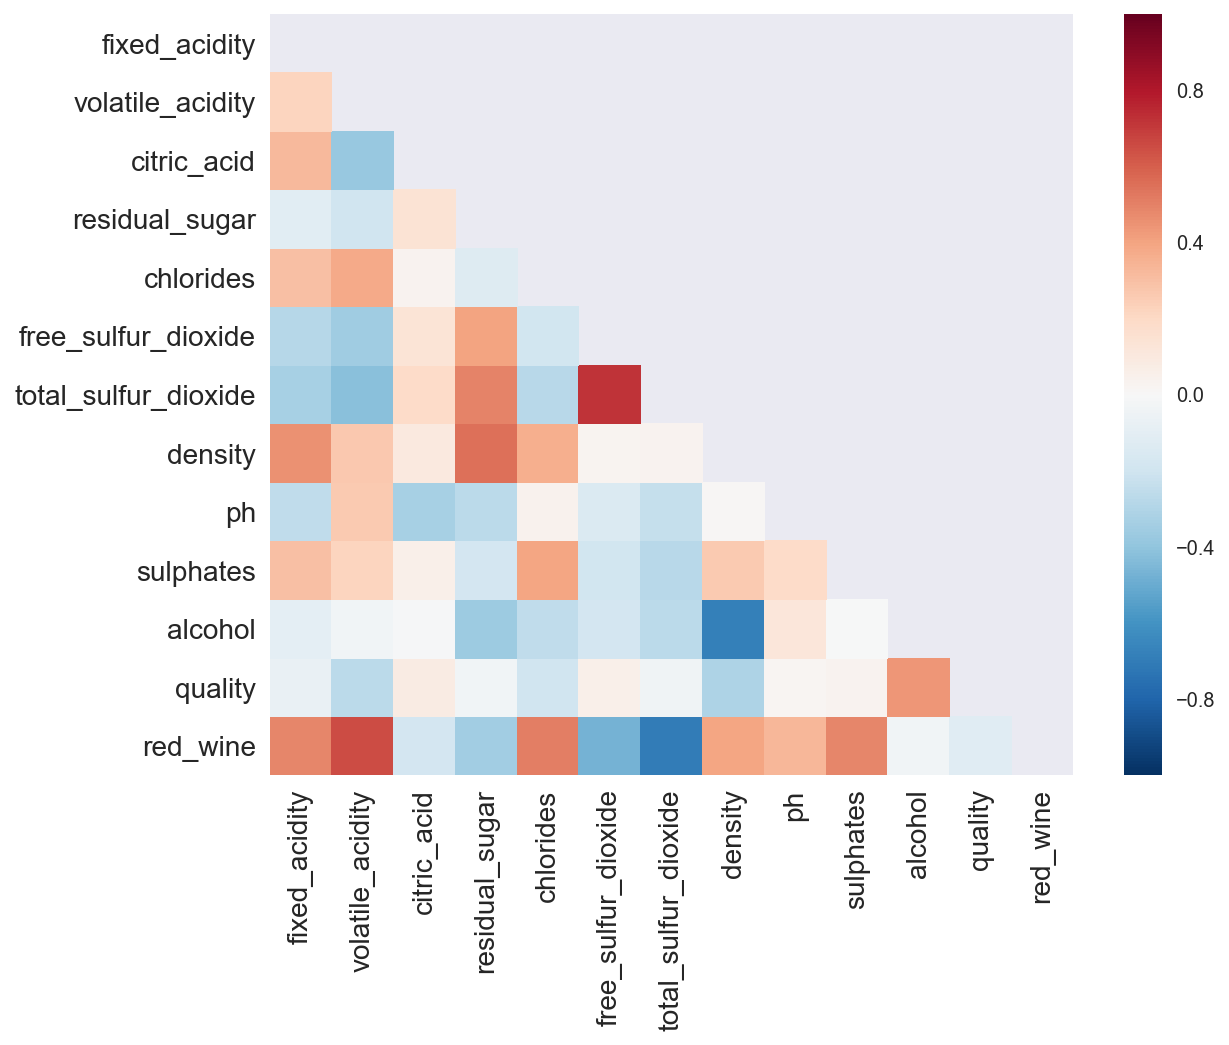

In [13]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(wine_corr, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='standardization'></a>

## Standardizing predictors is required

---

With the Lasso and Ridge it is neccessary to standardize the predictor columns before constructing the models, even the dummy coded categorical variables. 


In [14]:
# Choose a target/dependent variable that we will predict
target = 'quality'

In [15]:
# select all the columns that are not the target
nc = [x for x in wine.columns if x != target]

# By subtracting the mean and dividing by the standard devation, the normalization procedure is putting 
# all of the predictor variables on the same scale (distributions with mean == 0 and standard deviation == 1)
# (Yes, we could have also used sklearn's StandardScaler.  Try it and see if you get the same answer! )
wine[nc] = (wine[nc] - wine[nc].mean()) / wine[nc].std()

Alternatively you can use sklearn, though it gives you an np array instead of a dataframe

In [17]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [18]:
wine_scaled = ss.fit_transform(wine[nc])

# At this point, the array can be imported into a df

### Create the target and predictor matrix 

We will be making two X, Y datasets. One of them will be dramatically more complex (and thus overfit).

1. The first is going to just be all the variables added together.
2. The second will have all interactions between the variables included. This should overfit the target quite a bit!

#### With sklearn

In [19]:
from sklearn.preprocessing import PolynomialFeatures

X = wine[nc].values
Y = wine[target].values

# Lets add unnecessary complexity
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_overfit = pf.fit_transform(X)
Y_overfit = Y

X.shape, X_overfit.shape

((6497, 12), (6497, 78))

#### With patsy (optional)

In [20]:
import patsy

# Get the non-target cols with a simple list comprehension
non_target_cols = [c for c in wine.columns if c != target]
print('Non-target columns are...')
print(non_target_cols)
print()

# Use some string adding and joining to make the simple model formula:
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print('The "simple" patsy formula is...')
print(formula_simple)
print()

# Make the complex formula:
formula_complex = target + ' ~ (' + ' + '.join(non_target_cols) + ')**2 -1'
print('The "complex" patsy formula is...')
print(formula_complex)
print()

# Create the X and Y pairs for both!
Y, X = patsy.dmatrices(formula_simple, data=wine, return_type='dataframe')
Yoverfit, Xoverfit = patsy.dmatrices(formula_complex, data=wine, return_type='dataframe')

Y = Y.values.ravel()
Yoverfit = Yoverfit.values.ravel()


Non-target columns are...
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'red_wine']

The "simple" patsy formula is...
quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine -1

The "complex" patsy formula is...
quality ~ (fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine)**2 -1



**Look at how the shapes of the X matrices differ. You can see that the Xoverfit has considerably more columns due to the creation of all possible two-way interactions.**

<a id='viz-ridge'></a>

## Defining and Visualizing the Ridge

---

### $$ \text{minimize:}\; MSE+Ridge = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \alpha\sum_{j=1}^p \beta_j^2$$

**Where:**

$\beta_j^2$ is the squared coefficient for variable $x_j$.

$\sum_{j=1}^n \beta_j^2$ is the sum of these squared coefficients for every variable in the model. This does **not** include the intercept $\beta_0$.

$\alpha$ is a constant for the _strength_ of the regularization parameter. The higher the value, the greater the impact of this new component in the loss function. If the value was zero, we would revert back to just the least squares loss function. If the value was a billion, however, the residual sum of squares component would have a much smaller effect on the loss/cost than the regularization term.

Now all **you** have to do is...

import the `Ridge` model class from sklearn.

In [21]:
from sklearn.linear_model import Ridge

This function iterates over a series of different alpha regularization parameters and stores the results of the model so that we can plot them interactively.

> This will not be part of your typical workflow.  This for learning purposes only!

In [22]:
def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list
        coefs.append(ridge_reg.coef_)
        
    return coefs

Alpha values for the ridge are best visualized on a logarithmic "magnitude" scale. Essentially, the effect of alpha on the coefficients does not increase linearly but by orders of magnitude. 

In [23]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

The plotting function below will:

 - Plot the effect of changing alpha on the coefficient size on a **path** graph
 - Plot the effect of changing alpha on the coefficient size on a **bar** graph
 
Each one gives informative information. It's just two different ways of visualizing the same thing. The chart is interactive so you can play around with the values of alpha across the specified range above.

In [24]:
# The cycler package lets us "cycle" throug colors.
# Just another thing i had to look up on stackoverflow. That's my life.
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,5)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(list(range(1, len(feature_names)+1)), coefs[-1], align='center', color=colors)
    ax2.set_xticks(list(range(1, len(feature_names)+1)))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()


Load the ipython widgets so we can make this plotting function interactive!

In [25]:
from ipywidgets import *
from IPython.display import display

The function and `interact` from ipywidgets lets me take some specified alphas that we have already calculated the coefficients for and plot them out.

In [26]:
def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.000001,5.0,0.05))

interactive(children=(FloatSlider(value=1e-06, description='log_of_alpha', max=5.0, min=1e-06, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.ridge_plot_runner(log_of_alpha=0)>

<a id='viz-lasso'></a>

## Defining and Visualizing the Lasso

---

Now we do the same thing as above but for the Lasso. You will be able to see how the coefficients change differently for both!  But first, let's define lasso.

Lasso regression takes a different approach. Instead of adding the sum of squared $\beta$ coefficients to the RSS, it adds the sum of the absolute values of the $\beta$ coefficients:

### $$ \text{minimize:}\; MSE + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \alpha\sum_{j=1}^p |\beta_j|$$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$.

$\alpha$ is again the strength of the regularization penalty component in the loss function. 

In [27]:
from sklearn.linear_model import Lasso

In [28]:
# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs


Alphas for the Lasso tend to effect regularization linearly rather than by orders of magnitude like in the ridge. 

A linear series of alphas is sufficient.

In [29]:
l_alphas = np.arange(0.001, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

Run the same plotting function above, but now with the calculated coefficients of alpha for the Lasso.

In [30]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, X.columns, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.001,0.2,0.0025))

interactive(children=(FloatSlider(value=0.001, description='alpha', max=0.2, min=0.001, step=0.0025), Output()), _dom_classes=('widget-interact',))

<function __main__.lasso_plot_runner(alpha=0)>

<a id='viz-elastic-net'></a>

## Visualizing the Elastic Net

---

Can't decide?  Buy both!!

The Elastic Net combines the Ridge and Lasso penalties.  It adds *both* penalties to the loss function:

> "[Elastic Net] allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge."
-- sklearn docs

### $$ \text{minimize:}\; MSE + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \alpha\rho\sum_{j=1}^p |\beta_j| + \alpha(1-\rho)\sum_{j=1}^p \beta_j^2$$

In the elastic net, the effect of the ridge versus the lasso is balanced by the $\rho$ parameter.  It is the ratio of Lasso penalty to Ridge penalty and must be between zero and one.

`ElasticNet` in sklearn has two parameters:
- `alpha`: the regularization strength.
- `l1_ratio`: the amount of L1 vs L2 penalty (i.e., $\rho$). An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.


In [31]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Lasso can "overpower" the Ridge penalty in some datasets, and so rather than an equal balance I'm just adding a little bit of Lasso in.

In [32]:
# This is the same as the ridge coefficient by alpha calculator
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [33]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

In [34]:
def enet_plot_runner(alpha=0.01):
    coef_plotter(enet_alphas, enet_coefs, X.columns, alpha, regtype='elastic net')

interact(enet_plot_runner, alpha=(0.0,1.0,0.005))

interactive(children=(FloatSlider(value=0.01, description='alpha', max=1.0, step=0.005), Output()), _dom_classes=('widget-interact',))

<function __main__.enet_plot_runner(alpha=0.01)>

<a id='model-performance'></a>

## Model performance of the Ridge, Lasso and Elastic Net on the overfit data

### (i.e., what do I actually need to do!)

---

Let's check out how the penalties affect the performance of our models. On the basic wine dataset there won't be much benefit to using regularization. We can switch over to the overfit data instead to see if regularization helps us control overfitting.

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

**Let's start with plain vanilla linear regression:**

In [39]:
lr = LinearRegression()
lr_cv_mean_mse = -cross_val_score(lr, X_overfit, Y_overfit, cv=5, scoring='neg_mean_squared_error').mean()
lr_cv_mean_r2 = cross_val_score(lr, X_overfit, Y_overfit, cv=5, scoring='r2').mean()
lr_cv_mean_mse, lr_cv_mean_r2

(0.6048196879255879, 0.19132770989380082)

### Ridge Regression

**Now let's make it into a Ridge regression by adding the penalty term:**

In [43]:
# somewhat redundant as default alpha is already 1 and alpha is already the first kwarg
alpha = 1.0
ridge_model = Ridge(alpha=alpha)
ridge_cv_mean_mse = -cross_val_score(ridge_model, X_overfit, Y_overfit, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cv_mean_r2 = cross_val_score(ridge_model, X_overfit, Y_overfit, cv=5, scoring='r2').mean()
ridge_cv_mean_mse, ridge_cv_mean_r2

(0.6040968285554185, 0.19232695686879936)

Which $\alpha$ to chose?  Let's search!

In [45]:
# generate 200 logarithmically spaced numbers between 10^0 and 10^5
r_alphas = np.logspace(0, 5, 200)

ridge_model = RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_model = ridge_model.fit(X_overfit, Y_overfit)

#ridge_cv_mean_mse = -cross_val_score(ridge_model, X_overfit, Y_overfit, cv=5, scoring='neg_mean_squared_error').mean()
#ridge_cv_mean_r2 = cross_val_score(ridge_model, X_overfit, Y_overfit, cv=5, scoring='r2').mean()
#ridge_cv_mean_mse, ridge_cv_mean_r2

In [46]:
# So what is the optimal value of alpha?
ridge_optimal_alpha = ridge_model.alpha_
print(ridge_optimal_alpha)

821.434358491943


In [49]:
# Let's average the CV scores for each value of alpha
ridge_cv_means = [np.mean(cv_alpha) for cv_alpha in ridge_model.cv_values_.T]

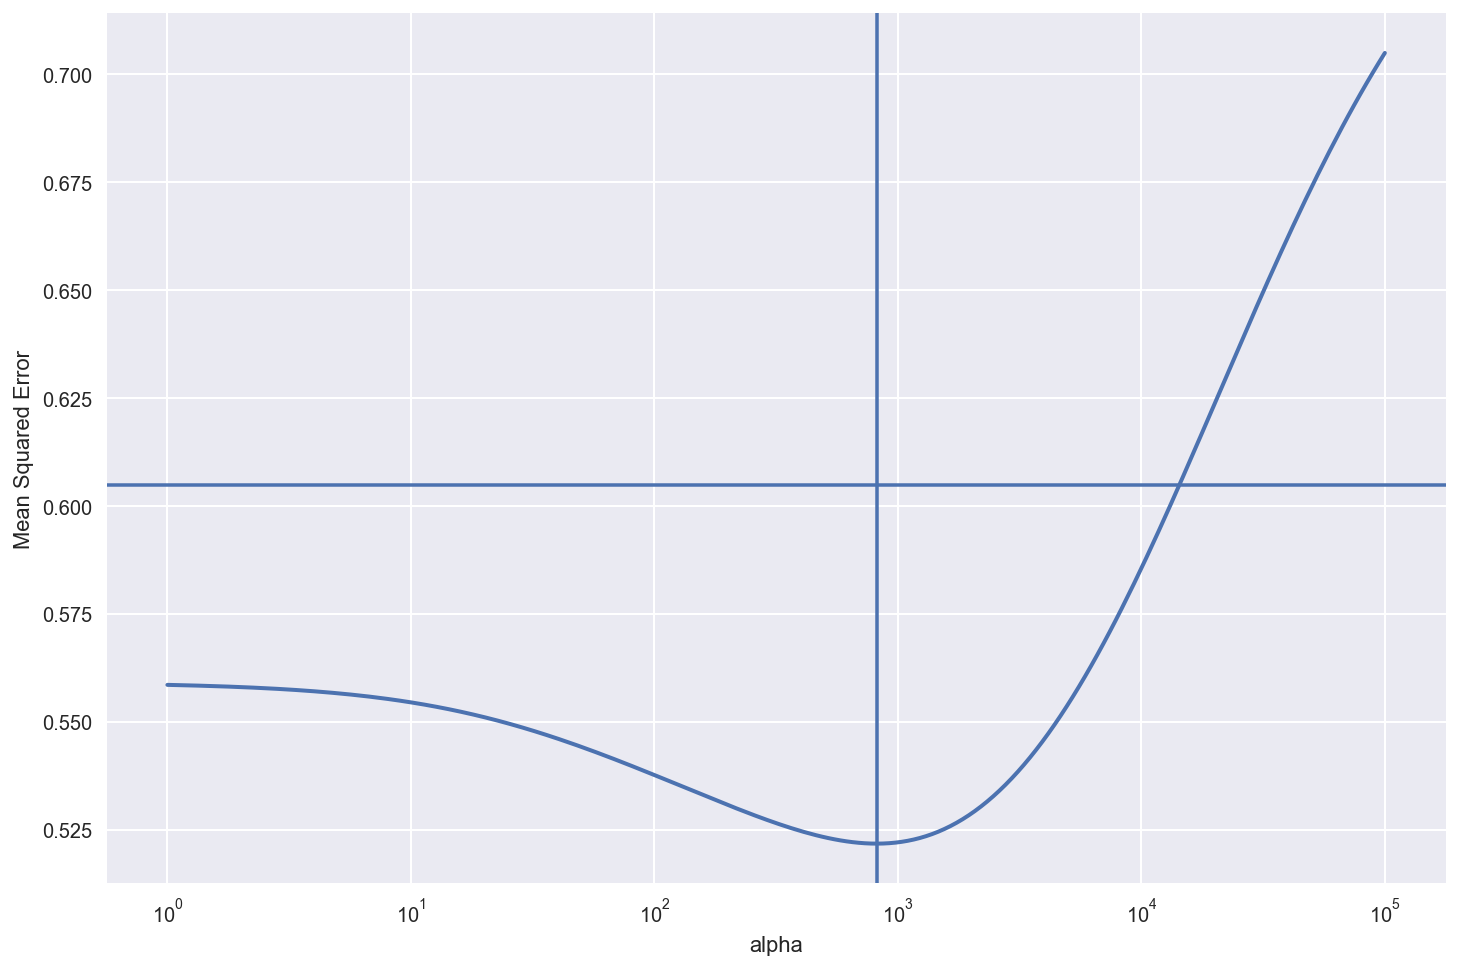

In [50]:
# A picture is worth a thousand words
def plot_cv(alphas, cv_means, optimal_alpha, lr_mse, log=False):
    # alphas = list of alphas
    # cv_means = list of CV mean MSE
    # optimal_alpha
    # lr_mse
    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()

    if log:
        ax.semilogx(alphas, cv_means, lw=2)
    else:
        ax.plot(alphas, cv_means, lw=2)
    ax.axvline(optimal_alpha)
    ax.axhline(lr_mse)
    ax.set_xlabel('alpha')
    ax.set_ylabel('Mean Squared Error')
    
plot_cv(ridge_model.alphas, ridge_cv_means, ridge_optimal_alpha, lr_cv_mean_mse, log=True)

Above we have seen how MSE is minimized at the optimal $\alpha$.  Let's get the corresponding value of $R^2$.

In [51]:
ridge_model.predict(X_overfit)

array([4.94738747, 5.16560934, 5.26847657, ..., 5.47661728, 6.65916145,
       6.29626486])

### Lasso Regression

In [52]:
from sklearn.linear_model import Lasso, LassoCV

In [53]:
# generate a list starting at .001 that gets as close as it can to .15 with a stepsize of .0025
l_alphas = np.arange(0.001, 0.15, 0.0025)

In [54]:
lasso_model = LassoCV(alphas=l_alphas, cv=5)
lasso_model.fit(X_overfit, Y_overfit)

LassoCV(alphas=array([0.001 , 0.0035, 0.006 , 0.0085, 0.011 , 0.0135, 0.016 , 0.0185,
       0.021 , 0.0235, 0.026 , 0.0285, 0.031 , 0.0335, 0.036 , 0.0385,
       0.041 , 0.0435, 0.046 , 0.0485, 0.051 , 0.0535, 0.056 , 0.0585,
       0.061 , 0.0635, 0.066 , 0.0685, 0.071 , 0.0735, 0.076 , 0.0785,
       0....21 , 0.1235, 0.126 , 0.1285, 0.131 , 0.1335, 0.136 , 0.1385,
       0.141 , 0.1435, 0.146 , 0.1485]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [55]:
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

0.011

In [57]:
# no transpose necessary
lasso_cv_means = [np.mean(cv_alpha) for cv_alpha in lasso_model.mse_path_]

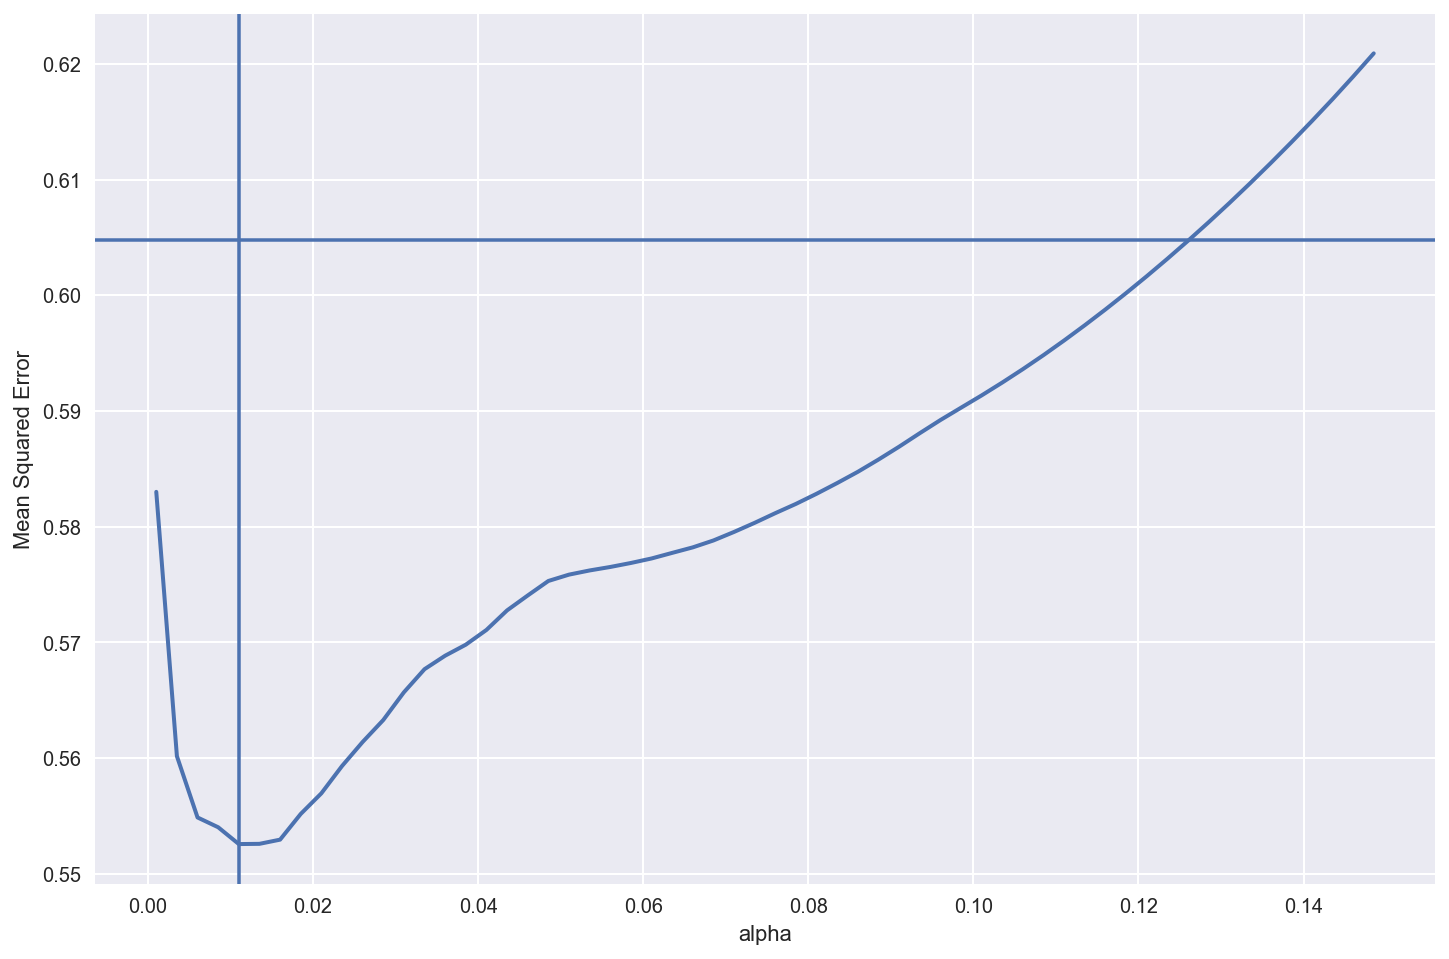

In [59]:
# plot_cv(lasso_model.alphas, lasso_cv_means, lasso_optimal_alpha, lr_cv_mean_mse, log=True)
plot_cv(lasso_model.alphas_, lasso_cv_means, lasso_optimal_alpha, lr_cv_mean_mse)

### ElasticNet Regression

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

## Take-aways

---

- **Ridge** is good at "shrinking" model coefficients.
- **Lasso** is good at eliminating coefficients.
- **ElasticNet** combines Ridge and Lasso.

In all cases, "regularization strength" is defined by a parameter $\alpha$ (sometimes called $\lambda$):
- Increase $\alpha$ (turn up regularization) 
    - Increase bias
    - Decrease variance
- Decrease $\alpha$ (turn down regularization) 
    - Decrease bias
    - Increase variance
    
Bottom line? 

- The Ridge is best suited to deal with multicollinearity. 
- Lasso also deals with multicollinearity between variables, but in a more brutal way (it "zeroes out" the less effective variable).
- The Lasso is particularly useful when you have redundant or unimportant variables. If you have 1000 variables in a dataset the Lasso can perform "feature selection" automatically for you by forcing coefficients to be zero.
- Elastic Net combines both.